In [1]:
from langchain_community.utilities import SerpAPIWrapper
from dotenv import load_dotenv
import os
from langchain_core.tools import Tool

load_dotenv()
os.environ["SERPAPI_API_KEY"]=os.getenv("SERPAPI_API_KEY")

# Initialize the wrapper. It will use the SERPAPI_API_KEY environment variable.
search_wrapper = SerpAPIWrapper(params={'engine': 'google'})



search = Tool(
    name="google_search",
    description="Search Google for current information. Use this for questions about recent events, news, or facts.",
    func=search_wrapper.run
)


In [3]:
# load librarys
from typing_extensions import TypedDict
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
import streamlit as st
from typing import Annotated
from langgraph.graph.message import add_messages
import os
from dotenv import load_dotenv
#from tools import search
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


#load llm and his key
load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm_groq=ChatGroq(model="openai/gpt-oss-20b")

## Reducers and creating state
class State(TypedDict):
    messages:Annotated[list,add_messages]


#initiating tools

tools=[search]
llm_with_tools=llm_groq.bind_tools(tools)
#functions for llms
def superbot(state:State):
    return {"messages":[llm_groq.invoke(state['messages'])]}


def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


# initiating state
graph=StateGraph(State)

## node
#graph.add_node("SuperBot",superbot)
graph.add_node("tool_calling_llm", tool_calling_llm)
graph.add_node("tools", ToolNode(tools))
## Edges

graph.add_edge(START, "tool_calling_llm")
graph.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
graph.add_edge("tools", END)


graph_builder=graph.compile()

In [74]:
test_message="what is the la liga s matchs"
result=graph_builder.invoke({'messages': HumanMessage(content=test_message)})

In [75]:
result

{'messages': [HumanMessage(content='what is the la liga s matchs', additional_kwargs={}, response_metadata={}, id='e6ee3fcd-1cb6-474a-9766-0a2b8cfed5c6'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "what is the la liga s matchs". Likely they want schedule of La Liga matches. They might be asking for upcoming matches or current season schedule. The user typed "la liga s matchs" - maybe they mean "La Liga\'s matches". We need to provide schedule. Since it\'s up-to-date, we may need to search for current schedule. Use google_search.', 'tool_calls': [{'id': 'fc_f0486c99-0c7d-4a66-891d-22955cbbaf3e', 'function': {'arguments': '{"__arg1":"La Liga matches schedule 2025-2026"}', 'name': 'google_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 114, 'prompt_tokens': 146, 'total_tokens': 260, 'completion_time': 0.116042787, 'completion_tokens_details': {'reasoning_tokens': 80}, 'prompt_time': 0.007058891, 'prompt_tokens_

In [58]:
len(result["messages"])

2

In [76]:
result["messages"][2]

ToolMessage(content='{"title": "LaLiga", "games": [{"tournament": "LaLiga", "venue": "Camp Nou", "venue_kgmid": "/m/01ggjl", "date": "Today", "time": "10:15 AM", "video_highlights": {"link": "https://stories.laliga.com/games/69985bdc082833050dcc3251.html", "thumbnail": "https://serpapi.com/searches/699b1d3dc7544314914f1144/images/vddXdqVZ0eZFvGOpOADwdvQd9b7fcPDmjLkzoNuiv5jWhqnXkXlw43-P2kmy2iIsSv8RwVc_DU1ZcTvMCuJnvA.jpeg"}, "teams": [{"name": "Barcelona", "kgmid": "/m/0hvgt"}, {"name": "Levante", "kgmid": "/m/01njml"}]}, {"tournament": "LaLiga", "venue": "Balaídos", "venue_kgmid": "/m/07_p1_", "date": "Today", "time": "12:30 PM", "video_highlights": {"link": "https://stories.laliga.com/games/69985ceeed2ae1c95bf69dbc.html", "thumbnail": "https://serpapi.com/searches/699b1d3dc7544314914f1144/images/vddXdqVZ0eZFvGOpOADwdqoNmKDRsM9o4-ZGIA-4TdHxXs6vRPgCWsCwqgN3qYSIuzj49_lZQtaiv5jOAxD9ag.jpeg"}, "teams": [{"name": "Celta Vigo", "kgmid": "/m/0266sb_"}, {"name": "Mallorca", "kgmid": "/m/01vqc7"

In [77]:
if result["messages"][2]:
    print("tool available")
else:
    print("no tools")

tool available


In [78]:
result.get("ToolMessage")

In [79]:
result["messages"][2].name

'google_search'

In [80]:
if result["messages"][2]:
    print("tool available")
    result["messages"][2].name
else:
    print("no tools")
    result["messages"][-1].content

tool available


In [81]:
result["messages"]

[HumanMessage(content='what is the la liga s matchs', additional_kwargs={}, response_metadata={}, id='e6ee3fcd-1cb6-474a-9766-0a2b8cfed5c6'),
 AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "what is the la liga s matchs". Likely they want schedule of La Liga matches. They might be asking for upcoming matches or current season schedule. The user typed "la liga s matchs" - maybe they mean "La Liga\'s matches". We need to provide schedule. Since it\'s up-to-date, we may need to search for current schedule. Use google_search.', 'tool_calls': [{'id': 'fc_f0486c99-0c7d-4a66-891d-22955cbbaf3e', 'function': {'arguments': '{"__arg1":"La Liga matches schedule 2025-2026"}', 'name': 'google_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 114, 'prompt_tokens': 146, 'total_tokens': 260, 'completion_time': 0.116042787, 'completion_tokens_details': {'reasoning_tokens': 80}, 'prompt_time': 0.007058891, 'prompt_tokens_details': None

In [82]:
result["messages"][-1].tool_calls

AttributeError: 'ToolMessage' object has no attribute 'tool_calls'

In [ ]:
if result["messages"][-1].tool_calls==[]:
    print("no tools")
    result["messages"][-1].content
else:
    print(" tools called ")
    result["messages"][-1].content

AttributeError: 'ToolMessage' object has no attribute 'tool_calls'

In [88]:
test_message="what is the last news give me one"

In [93]:
# After getting the result from graph_builder.invoke()
result = graph_builder.invoke({'messages': test_message})

# Check if the last message has tool calls
if result["messages"][1].tool_calls:
    print("🔧 Tools were called")
    # Loop through all tool calls
    for tool_call in result["messages"][1].tool_calls:
        print(f"   - Tool name: {tool_call['name']}")
    # Get the content (might be empty if tools were called)
    print(f"\n📝 Response: {result['messages'][-1].content}")
else:
    print("🤖 Source: LLM (no tools used)")
    print(f"📝 Response: {result['messages'][-1].content}")

🔧 Tools were called
   - Tool name: google_search

📝 Response: [{"title": "Xi Gains Leverage Before Trump Summit After Tariff Reversal", "link": "https://www.bloomberg.com/news/articles/2026-02-22/xi-gains-upper-hand-before-trump-summit-after-us-tariff-reversal", "source": "Bloomberg.com", "source_logo": "https://serpapi.com/searches/699b1f3e7bf2f90b61851247/images/_zQ-yq9s1IlsYfLzt01Gk32AIZM0l_uF2SIOvY43RJw.png", "date": "5 hours ago"}, {"title": "Homeland security to suspend TSA PreCheck and Global Entry airport security programs", "link": "https://www.theguardian.com/us-news/2026/feb/22/homeland-security-suspends-tsa-precheck-global-entry-airport-security-programs", "source": "The Guardian", "source_logo": "https://serpapi.com/searches/699b1f3e7bf2f90b61851247/images/GIpbFK_N1gX7czSjot3DlnU7L1V4uWt-LPP9VAmlvXY.png", "date": "2 hours ago"}, {"title": "How many inches of snow are we getting today? Latest map shows 2 feet for some", "link": "https://www.nbcnewyork.com/weather/weather-s

In [ ]:
result["messages"]

[HumanMessage(content='what is the last news give me one', additional_kwargs={}, response_metadata={}, id='414abc02-aed5-4175-b07c-4ed4c16f5985'),
 AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "what is the last news give me one". We need to search for current news. Use google_search.', 'tool_calls': [{'id': 'fc_0d9517ec-c347-4723-815b-fd8a3eb7f9ad', 'function': {'arguments': '{"__arg1":"latest news"}', 'name': 'google_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 147, 'total_tokens': 200, 'completion_time': 0.053304336, 'completion_tokens_details': {'reasoning_tokens': 27}, 'prompt_time': 0.007014133, 'prompt_tokens_details': None, 'queue_time': 0.003054201, 'total_time': 0.060318469}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e189667b30', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c85f1-deee-77

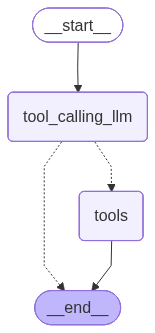

In [97]:
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [110]:
from langchain_core.messages import AIMessage, HumanMessage,SystemMessage
prompt="your goal is to take a raw text response and u need to structure informations "

def llm_structring_response(state:State):
    system_message = SystemMessage(content=prompt)
    
    # Combine system message with existing messages
    all_messages = [system_message] + state["messages"]
    return {"messages":[llm_with_tools.invoke(all_messages)]}

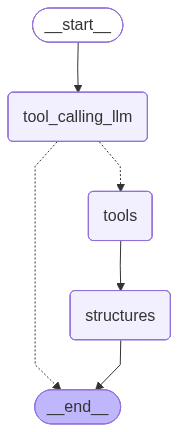

In [111]:
# initiating state
graph=StateGraph(State)

## node
#graph.add_node("SuperBot",superbot)
graph.add_node("tool_calling_llm", tool_calling_llm)
graph.add_node("tools", ToolNode(tools))
graph.add_node("structures", llm_structring_response)

## Edges

graph.add_edge(START, "tool_calling_llm")
graph.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
graph.add_edge("tools", "structures")
graph.add_edge("structures", END)



graph_builder=graph.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [112]:
test_message="what is the gdp of morocco latesst"
result = graph_builder.invoke({'messages': test_message})

In [113]:
result

{'messages': [HumanMessage(content='what is the gdp of morocco latesst', additional_kwargs={}, response_metadata={}, id='d84c8c99-b5ad-4280-8f03-3c9e9ed93892'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "what is the gdp of Morocco latest". We need the latest GDP figure for Morocco. We should use Google search to get up-to-date info. Use the function.', 'tool_calls': [{'id': 'fc_18959ad2-48e4-4092-8e91-888869215c07', 'function': {'arguments': '{"__arg1":"latest GDP of Morocco"}', 'name': 'google_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 150, 'total_tokens': 218, 'completion_time': 0.070460774, 'completion_tokens_details': {'reasoning_tokens': 40}, 'prompt_time': 0.007286347, 'prompt_tokens_details': None, 'queue_time': 0.016224099, 'total_time': 0.077747121}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_9b8528b477', 'service_tier': 'on_demand', 'finish_reason': 'too

In [114]:
# Check if the last message has tool calls
if result["messages"][1].tool_calls:
    print("🔧 Tools were called")
    # Loop through all tool calls
    for tool_call in result["messages"][1].tool_calls:
        print(f"   - Tool name: {tool_call['name']}")
    # Get the content (might be empty if tools were called)
    print(f"\n📝 Response: {result['messages'][-1].content}")
else:
    print("🤖 Source: LLM (no tools used)")
    print(f"📝 Response: {result['messages'][-1].content}")

🔧 Tools were called
   - Tool name: google_search

📝 Response: **Morocco – Latest GDP (Current US $)**  

| Year (latest available) | GDP (current US $) | Source |
|--------------------------|--------------------|--------|
| **2025 (IMF estimate)** | **$179.61 billion** | IMF World Economic Outlook (2025) |
| **2024 (World Bank)**   | $154.43 billion | World Bank World Development Indicators |
| **2024 (IMF estimate)** | $160.61 billion | IMF World Economic Outlook (2024) |
| **2023 (World Bank)**   | $144.42 billion | World Bank World Development Indicators |

### Key Points

- **2025 IMF projection**: Morocco’s nominal GDP is expected to reach **$179.61 bn** in 2025, reflecting a rebound from the pandemic‑related slowdown and continued growth in key sectors (tourism, agriculture, and manufacturing).
- **2024 World Bank figure**: The latest *official* figure from the World Bank is **$154.43 bn** for 2024, slightly lower than the IMF 2024 estimate ($160.61 bn), but still showing a heal

In [148]:
from langchain_community.document_loaders import WebBaseLoader
from bs4 import BeautifulSoup

# Simple approach - let the loader handle it
loader_multiple_pages = WebBaseLoader(
    "https://arxiv.org/abs/1706.03762"
)

docs = loader_multiple_pages.load()
docs[0].metadata.get("title", "No title")

'[1706.03762] Attention Is All You Need'